In [1]:
!pip install pycocotools

In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-1ojiqh1b
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-1ojiqh1b
  Resolved https://github.com/facebookresearch/detectron2.git to commit b1c43ffbc995426a9a6b5c667730091a384e0fa4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 45.3 MB/s eta 0:00:0000:01
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6345242 sha256=0a2e1409aa9d0f16b0926e29bf7812a702a0907216faa0426bd4e33e89fc29b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-qs_lor5t/wheels/47/e5/15/94c80df2ba8

In [3]:
import numpy as np
import cv2, random, os
import matplotlib.pyplot as plt

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo

from detectron2.engine import DefaultTrainer

from detectron2.engine import DefaultPredictor

from detectron2.config import get_cfg

from detectron2.utils.visualizer import Visualizer

from detectron2.structures import BoxMode

from detectron2.data import DatasetCatalog, MetadataCatalog

from detectron2.evaluation import COCOEvaluator, inference_on_dataset

from detectron2.data import build_detection_test_loader

In [11]:
def get_regn_plate_dicts(data_root, txt_file):
    dataset_dicts = []
    base_image_filenames = []

    files = os.listdir(os.path.join(data_root, txt_file))
    for file in files:
        image_file = os.path.splitext(file)[0] + '.jpg'
        base_image_filenames.append(image_file)

    for idx, base_file in enumerate(base_image_filenames):
        record = {}

        image_path = os.path.join(data_root, os.path.dirname(txt_file), base_file)

        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to load image: {image_path}")
        height, width = img.shape[:2]

        record['file_name'] = image_path
        record['image_id'] = idx
        record['height'] = height
        record['width'] = width

        image_name = os.path.splitext(base_file)[0]
        
        annotation_path = os.path.join(data_root, txt_file, image_name + ".txt")
        annotation_rows = []

        if not os.path.exists(annotation_path):
            print(f"Annotation file not found: {annotation_path}")
            continue

        with open(annotation_path, 'r') as f:
            for line in f:
                temp = line.rstrip().split(" ")
                annotation_rows.append(temp)
        objs = []
        for row in annotation_rows:
            xmin = int(float(row[3]))
            ymin = int(float(row[4]))
            xmax = int(float(row[5]))
            ymax = int(float(row[6]))

            obj = {
                'bbox' : [xmin, ymin, xmax, ymax],
                'bbox_mode': BoxMode.XYXY_ABS,
                'category_id': 0,
                'iscrowd': 0
            }
            objs.append(obj)

        record['annotations'] = objs
        dataset_dicts.append(record)

    return dataset_dicts

        

In [6]:
data_root = '/kaggle/input/dataset/Dataset'
train_txt = '/kaggle/input/dataset/Dataset/train/Vehicle registration plate/Label'
val_txt = '/kaggle/input/dataset/Dataset/validation/Vehicle registration plate/Label'

train_data_name = 'train_regn_plate'
val_data_name = 'val_regn_plate'

thing_classes = ['regn_plate']

output_dir = 'outputs'

def count_lines(fname):
    fnames = os.listdir(fname)
    return len(fnames)

train_img_count = count_lines(os.path.join(data_root, train_txt))

In [7]:
DatasetCatalog.register(name = train_data_name,
                       func= lambda: get_regn_plate_dicts(data_root, train_txt))
train_metadata = MetadataCatalog.get(train_data_name).set(thing_classes = thing_classes)

DatasetCatalog.register(name=val_data_name,
                        func=lambda: get_regn_plate_dicts(data_root, val_txt))
val_metadata = MetadataCatalog.get(val_data_name).set(thing_classes=thing_classes)

In [12]:
val_data_dict = get_regn_plate_dicts(data_root, val_txt)

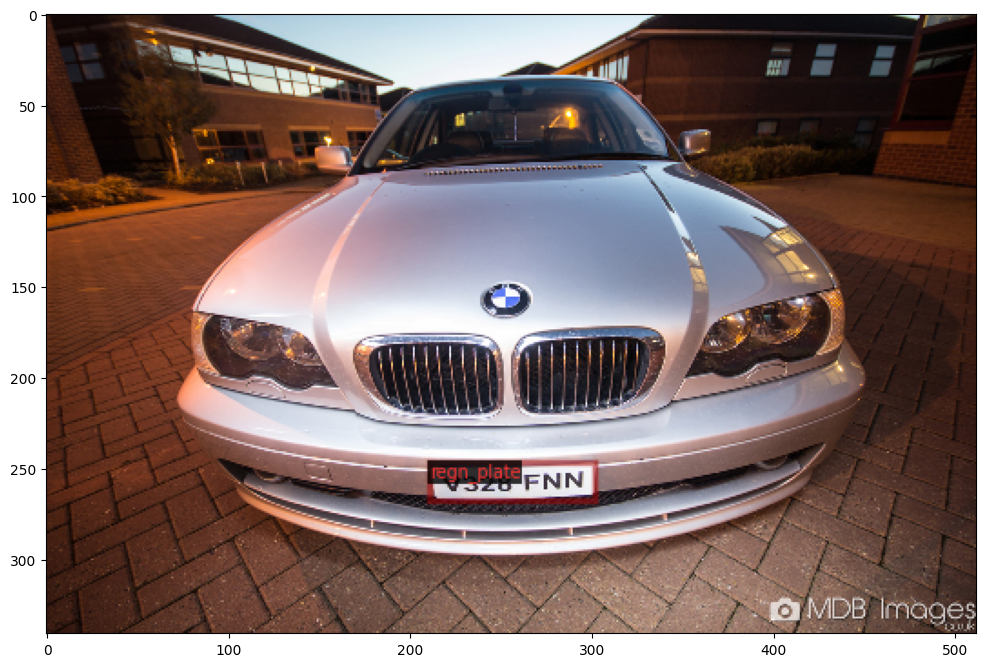

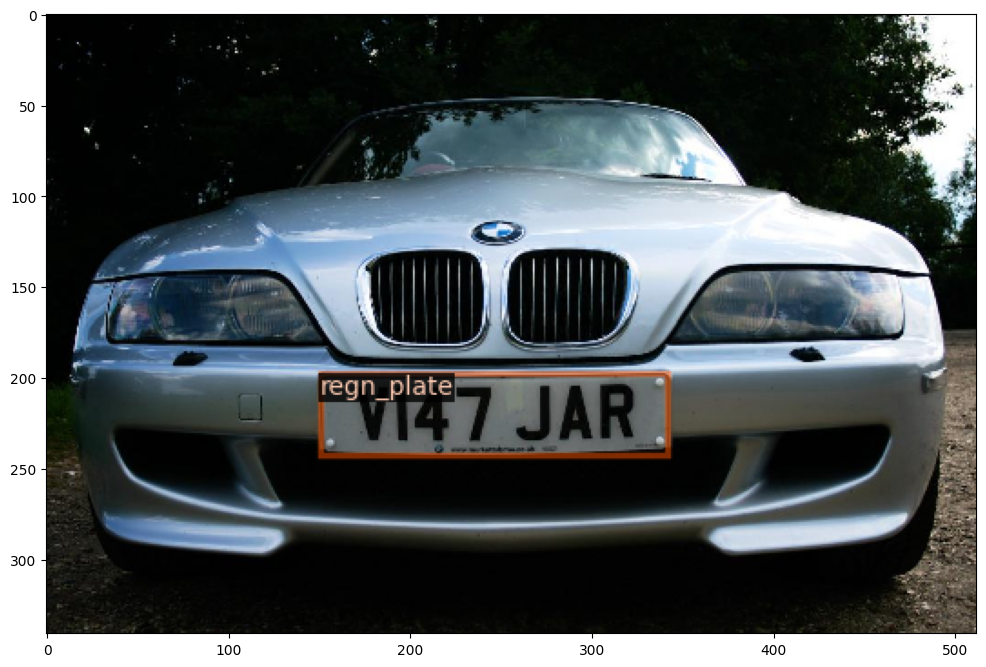

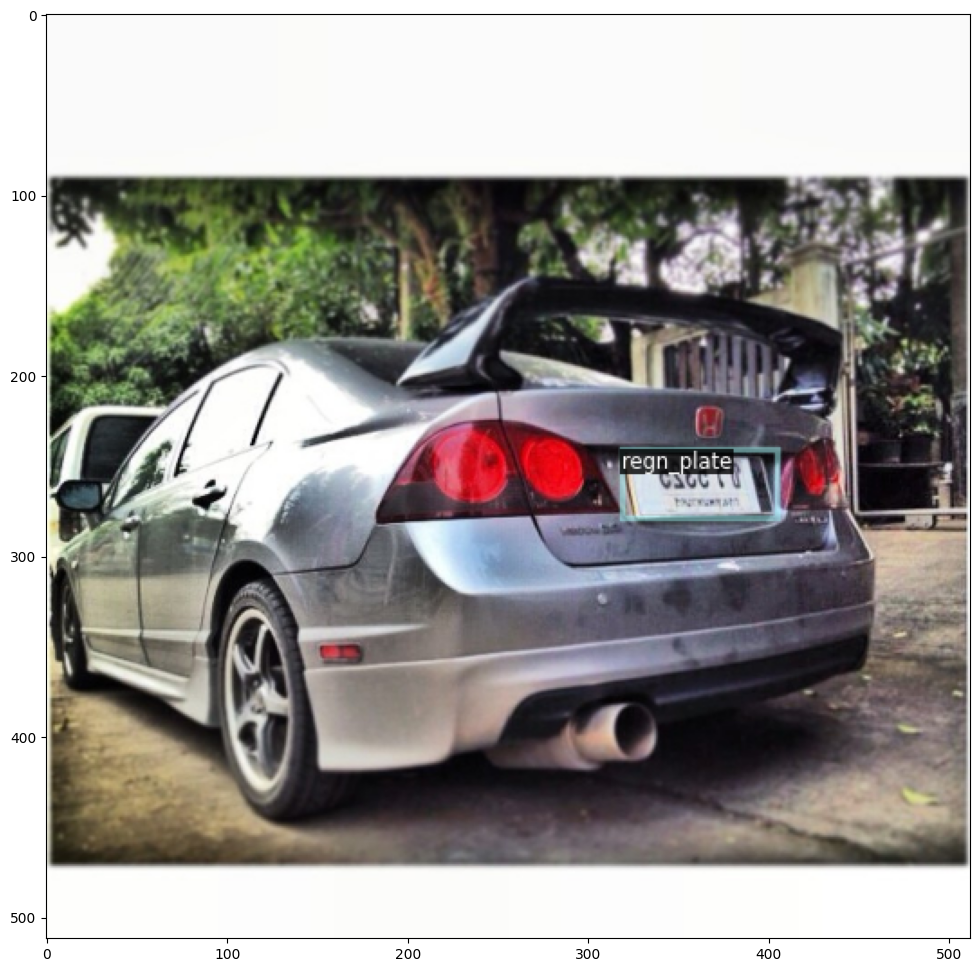

In [13]:
for d in random.sample(val_data_dict, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1],
                           metadata = val_metadata,
                           scale = 0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (12, 12))
    plt.imshow(vis.get_image())
    plt.show()

### Training

In [15]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/retinanet_R_50_FPN_3x.yaml'))

cfg.DATASETS.TRAIN = (train_data_name,)

cfg.DATASETS.TEST = ()

In [17]:
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url('COCO-Detection/retinanet_R_50_FPN_3x.yaml')

# slover configuration
cfg.SOLVER.IMS_PER_BATCH = 8

cfg.SOLVER.BASE_LR = 0.0001

epoch = 2
max_iter = int(epoch * train_img_count / cfg.SOLVER.IMS_PER_BATCH)

cfg.SOLVER.MAX_ITER = max_iter

In [18]:
cfg.MODEL.RETINANET.NUM_CLASSES = len(thing_classes)
cfg.OUTPUT_DIR = output_dir

os.makedirs(cfg.OUTPUT_DIR, exist_ok = True)

In [19]:
%load_ext tensorboard

%tensorboard --logdir outputs

<IPython.core.display.Javascript object>

In [20]:
trainer = DefaultTrainer(cfg)

trainer.resume_or_load(resume=False)

trainer.train()

[12/31 22:35:46 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_5bd44e.pkl: 152MB [00:00, 164MB/s]                             


[12/31 22:37:41 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/31 22:38:05 d2.utils.events]:  eta: 0:21:21  iter: 19  total_loss: 2.003  loss_cls: 1.282  loss_box_reg: 0.7192    time: 1.0208  last_time: 0.9890  data_time: 0.0746  last_data_time: 0.0806   lr: 1.9981e-06  max_mem: 6093M
[12/31 22:38:27 d2.utils.events]:  eta: 0:20:54  iter: 39  total_loss: 1.697  loss_cls: 1.142  loss_box_reg: 0.5357    time: 0.9875  last_time: 0.9163  data_time: 0.0743  last_data_time: 0.1076   lr: 3.9961e-06  max_mem: 6101M
[12/31 22:38:47 d2.utils.events]:  eta: 0:20:40  iter: 59  total_loss: 1.724  loss_cls: 1.082  loss_box_reg: 0.626    time: 0.9828  last_time: 1.0485  data_time: 0.0677  last_data_time: 0.1355   lr: 5.9941e-06  max_mem: 6101M
[12/31 22:39:06 d2.utils.events]:  eta: 0:20:21  iter: 79  total_loss: 1.59  loss_cls: 1.076  loss_box_reg: 0.4368    time: 0.9854  last_time: 0.9619  data_time: 0.0653  last_data_time: 0.0419   lr: 7.9921e-06  max_mem: 6102M
[12/31 22:39:26 d2.utils.events]:  eta: 0:20:10  iter: 99  total_loss: 1.602  loss_cls: 1.141 

In [21]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, 'model_final.pth')

cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5

cfg.DATASETS.TEST = (val_data_name,)

predictor = DefaultPredictor(cfg)

[12/31 23:43:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from outputs/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

/kaggle/input/dataset/Dataset/validation/Vehicle registration plate/62bb93bbd270dd9a.jpg
{'instances': Instances(num_instances=1, image_height=684, image_width=1024, fields=[pred_boxes: Boxes(tensor([[666.8540, 417.6807, 742.2350, 449.2500]], device='cuda:0')), scores: tensor([0.9477], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


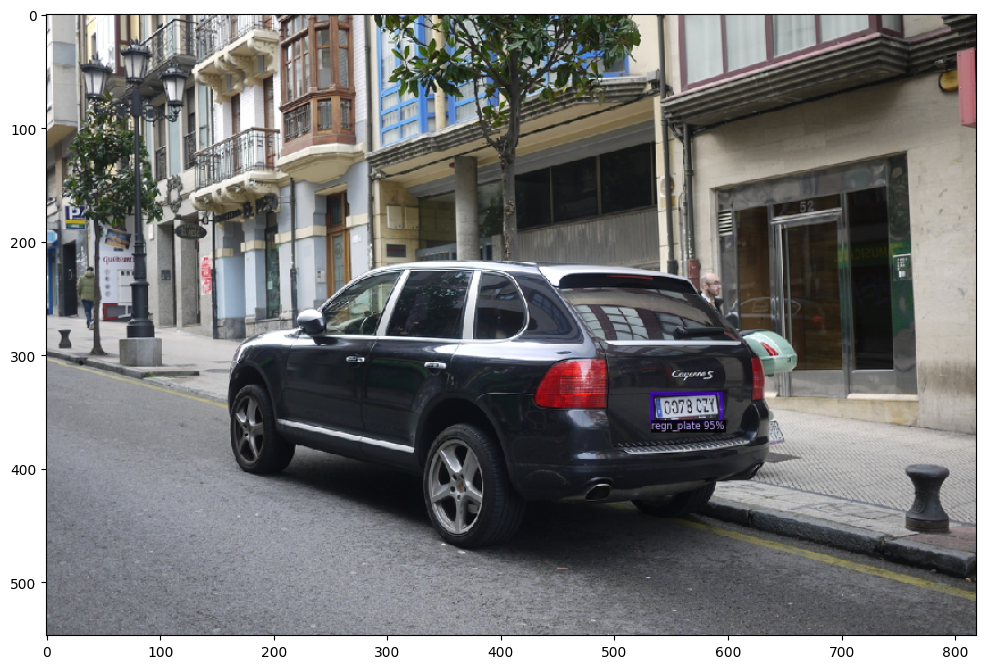

/kaggle/input/dataset/Dataset/validation/Vehicle registration plate/f9f539977bfea25e.jpg
{'instances': Instances(num_instances=1, image_height=683, image_width=1024, fields=[pred_boxes: Boxes(tensor([[448.5835, 496.3044, 569.1771, 553.3250]], device='cuda:0')), scores: tensor([0.9727], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


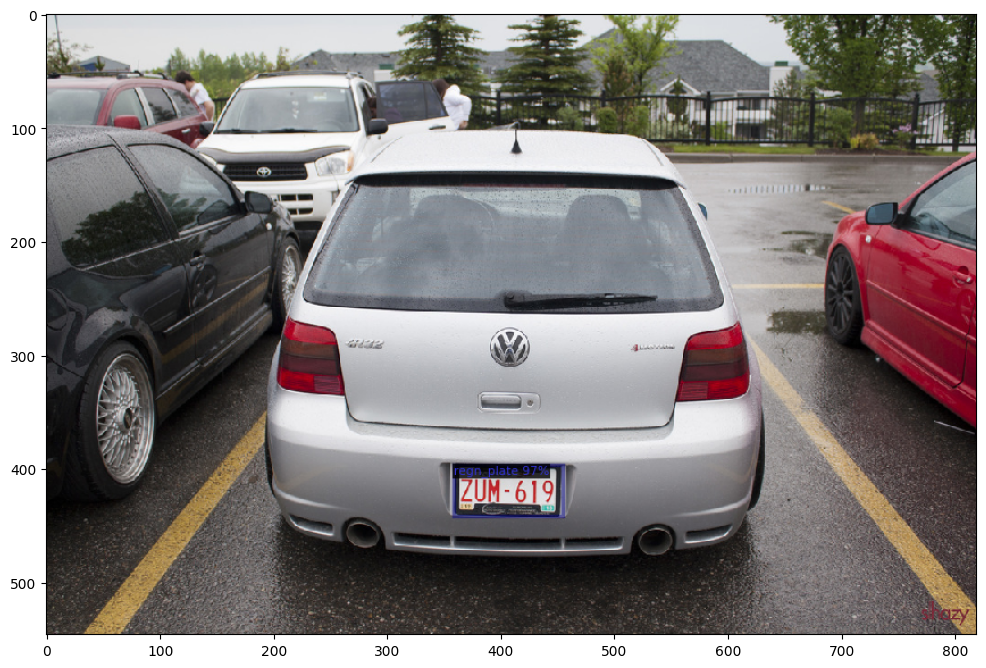

/kaggle/input/dataset/Dataset/validation/Vehicle registration plate/e82f13b4a2fe69f3.jpg
{'instances': Instances(num_instances=1, image_height=768, image_width=1024, fields=[pred_boxes: Boxes(tensor([[166.3942, 480.6700, 935.8489, 678.7991]], device='cuda:0')), scores: tensor([0.6849], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


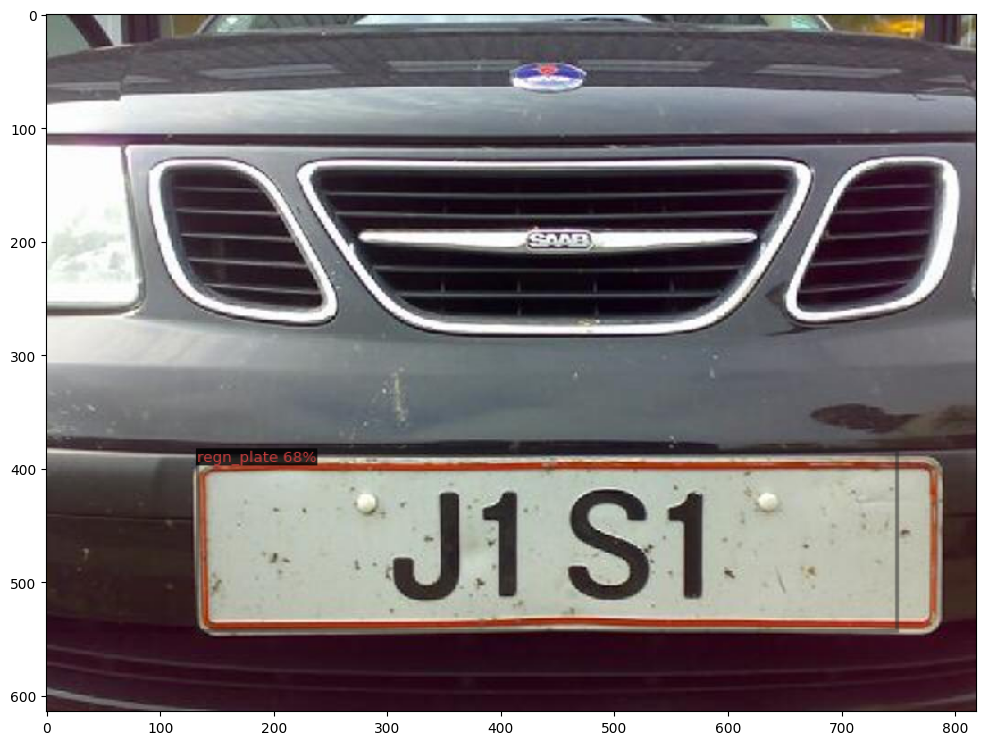

/kaggle/input/dataset/Dataset/validation/Vehicle registration plate/fb55b73f241bf50a.jpg
{'instances': Instances(num_instances=1, image_height=693, image_width=1024, fields=[pred_boxes: Boxes(tensor([[360.2066, 396.8625, 677.6437, 490.5791]], device='cuda:0')), scores: tensor([0.8103], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


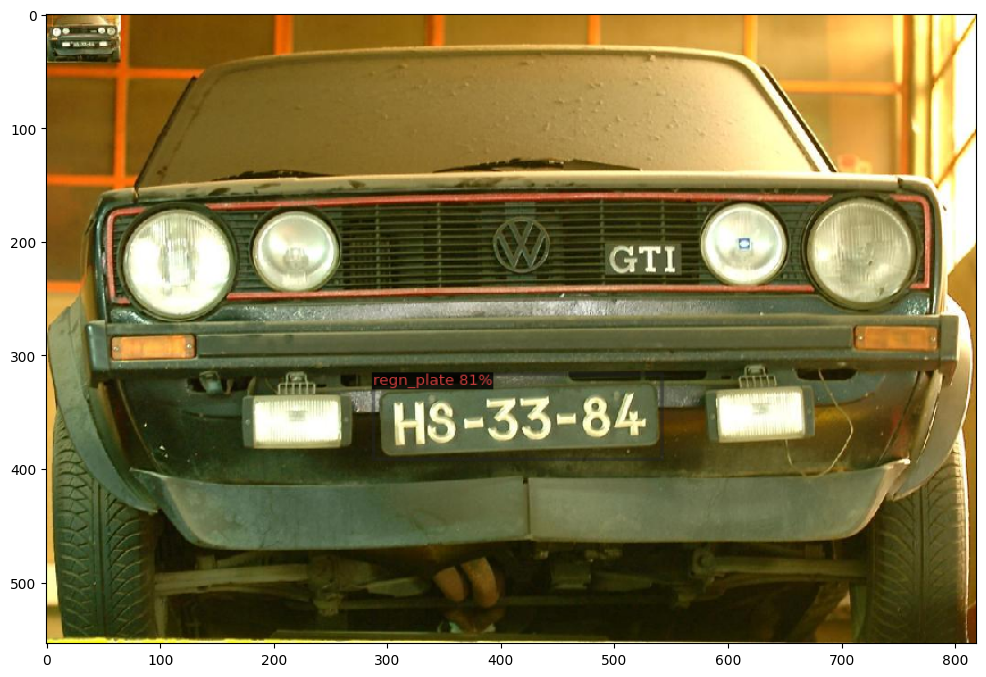

/kaggle/input/dataset/Dataset/validation/Vehicle registration plate/2bd26c63ebf598b7.jpg
{'instances': Instances(num_instances=1, image_height=683, image_width=1024, fields=[pred_boxes: Boxes(tensor([[669.0287, 355.7751, 798.9642, 420.5723]], device='cuda:0')), scores: tensor([0.9839], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}


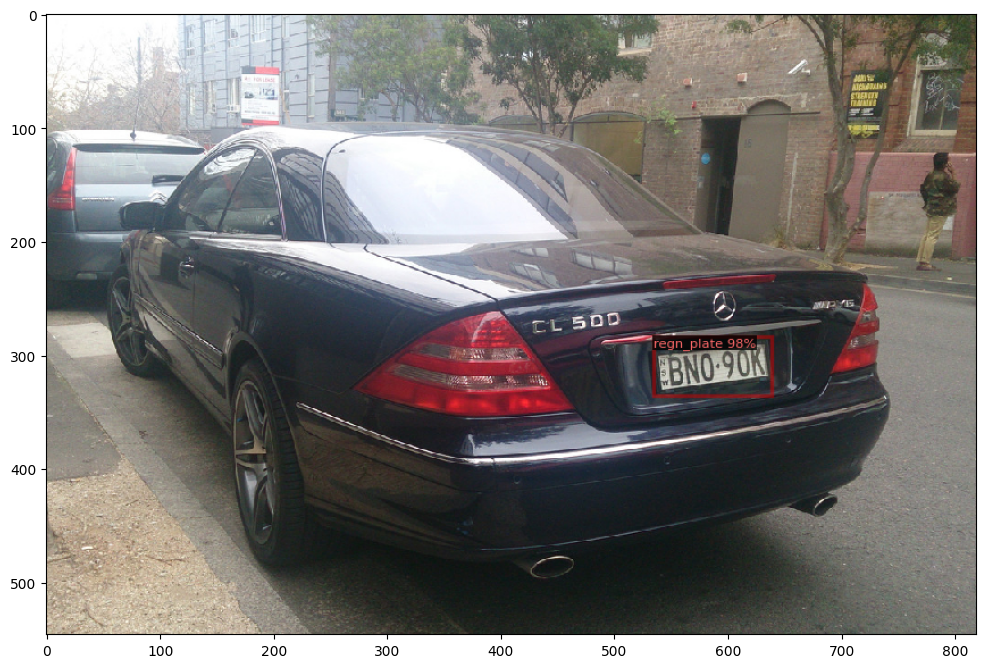

In [22]:
for d in random.sample(val_data_dict, 5):
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print(outputs)
    v = Visualizer(im[:,:,::-1],
                  metadata = val_metadata,
                  scale = 0.8
                  )
    v = v.draw_instance_predictions(outputs['instances'].to('cpu'))
    plt.figure(figsize = (12, 12))
    plt.imshow(v.get_image())
    plt.show()

In [24]:
eval_dir = os.path.join(cfg.OUTPUT_DIR, 'coco_eval')
os.makedirs(eval_dir, exist_ok = True)

evaluator = COCOEvaluator(dataset_name = val_data_name,
                         output_dir = eval_dir,
                         distributed = False)

val_loader = build_detection_test_loader(cfg, val_data_name)

inference_on_dataset(trainer.model, val_loader, evaluator)

[01/01 00:53:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/01 00:53:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/01 00:53:54 d2.data.common]: Serializing 386 elements to byte tensors and concatenating them all ...
[01/01 00:53:54 d2.data.common]: Serialized dataset takes 0.11 MiB
[01/01 00:53:54 d2.evaluation.evaluator]: Start inference on 386 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[01/01 00:53:55 d2.evaluation.evaluator]: Inference done 11/386. Dataloading: 0.0014 s/iter. Inference: 0.0595 s/iter. Eval: 0.0003 s/iter. Total: 0.0612 s/iter. ETA=0:00:22
[01/01 00:54:00 d2.evaluation.evaluator]: Inference done 90/386. Dataloading: 0.0018 s/iter. Inference: 0.0615 s/iter. Eval: 0.0003 s/iter. Total: 0.0636 s/iter. ETA=0:00:18
[01/01 00:54:05 d2.evaluation.evaluator]: Inference done 175/386. Dataloading: 0.0022 s/iter. Inference: 0.0588 s/iter. Eval: 0.0003 s/iter. Total: 0.0614 s/iter. ETA=0:00:12
[01/01 00:54:10 d2.evaluation.evaluator]: Inference done 260/386. Dataloading: 0.0021 s/iter. Inference: 0.0581 s/iter. Eval: 0.0003 s/iter. Total: 0.0606 s/iter. ETA=0:00:07
[01/01 00:54:15 d2.evaluation.evaluator]: Inference done 345/386. Dataloading: 0.0021 s/iter. Inference: 0.0578 s/iter. Eval: 0.0003 s/iter. Total: 0.0602 s/iter. ETA=0:00:02
[01/01 00:54:17 d2.evaluation.evaluator]: Total inference time: 0:00:22.987070 (0.060334 s / iter per device, on 1 devices)
[01

OrderedDict([('bbox',
              {'AP': 57.63726946141382,
               'AP50': 83.0009784667092,
               'AP75': 68.92296387429975,
               'APs': 19.670739775776504,
               'APm': 69.00686354001509,
               'APl': 68.48009112696043})])

In [25]:
!wget "https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1" -O projet3-input-video.mp4

--2025-01-01 00:55:18--  https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/3moy8n5xhnm4bz7hgqake/projet3-input-video.mp4?rlkey=v8j1l6iopdbgml9w4sho40ydm&dl=1 [following]
--2025-01-01 00:55:18--  https://www.dropbox.com/scl/fi/3moy8n5xhnm4bz7hgqake/projet3-input-video.mp4?rlkey=v8j1l6iopdbgml9w4sho40ydm&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


302 Found
Location: https://uc2489275c63375305b77f20a204.dl.dropboxusercontent.com/cd/0/inline/ChUkdzFpTLG-xrsp-7BMzzzdCx2k95da5E8GirQoz6p1wKqLPz-QowSSp5ETqMQTH_Fvii2j1fBXXRi9AYATGo0-V-0LnP37vL-G4jnIeGkIor1XYUq83s7GOWzO43KJQNanqP4b2LuH7om675VJ7-Qf/file?dl=1# [following]
--2025-01-01 00:55:18--  https://uc2489275c63375305b77f20a204.dl.dropboxusercontent.com/cd/0/inline/ChUkdzFpTLG-xrsp-7BMzzzdCx2k95da5E8GirQoz6p1wKqLPz-QowSSp5ETqMQTH_Fvii2j1fBXXRi9AYATGo0-V-0LnP37vL-G4jnIeGkIor1XYUq83s7GOWzO43KJQNanqP4b2LuH7om675VJ7-Qf/file?dl=1
Resolving uc2489275c63375305b77f20a204.dl.dropboxusercontent.com (uc2489275c63375305b77f20a204.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to uc2489275c63375305b77f20a204.dl.dropboxusercontent.com (uc2489275c63375305b77f20a204.dl.dropboxusercontent.com)|162.125.1.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2656250 (2.5M) [application/binary]
Saving to: ‘projet3-input-video.mp4’

projet3-input

In [26]:
def video_read_write(video_path):
    """
    Read video frames one-by-one, flip it, and write in the other video.
    video_path (str): path/to/video
    """
    video = cv2.VideoCapture(video_path)

    # Check if camera opened successfully
    if not video.isOpened():
        print("Error opening video file")
        return

    # create video writer
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_per_second = video.get(cv2.CAP_PROP_FPS)
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    output_fname = '{}_out.mp4'.format(os.path.splitext(video_path)[0])

    output_file = cv2.VideoWriter(
        filename=output_fname,
        # some installation of opencv may not support x264 (due to its license),
        # you can try other format (e.g. MPEG)
        fourcc=cv2.VideoWriter_fourcc('M','J','P','G'),
        fps=float(frames_per_second),
        frameSize=(1024, 576),
        isColor=True,
    )


    i = 0
    while video.isOpened():


        ret, frame = video.read()
        if ret:
          outputs = predictor(frame)

          v = Visualizer(frame[...,::-1],
                   metadata=val_metadata,
                   scale=0.8
                  )
          v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

          #plt.figure(figsize = (12, 12))
          #plt.imshow(v.get_image())
          #plt.show()


          output_file.write(v.get_image()[...,::-1])
#             cv2.imwrite('anpd_out/frame_{}.png'.format(str(i).zfill(3)), frame[:, ::-1, :])
          i += 1
        else:
            break

    video.release()
    output_file.release()

    return

In [27]:
video_read_write("projet3-input-video.mp4")